['MNIST', 'mnist.pkl.gz', 'kaggle_house_test.csv', 'test_catvnoncat.h5', 'kaggle_house_train.csv', 'kaggle_house_pred_train.csv', 'kaggle_house_pred_test.csv', 'FashionMNIST', 'train_catvnoncat.h5', 'test.h5']
['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt']
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
[]
['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBat

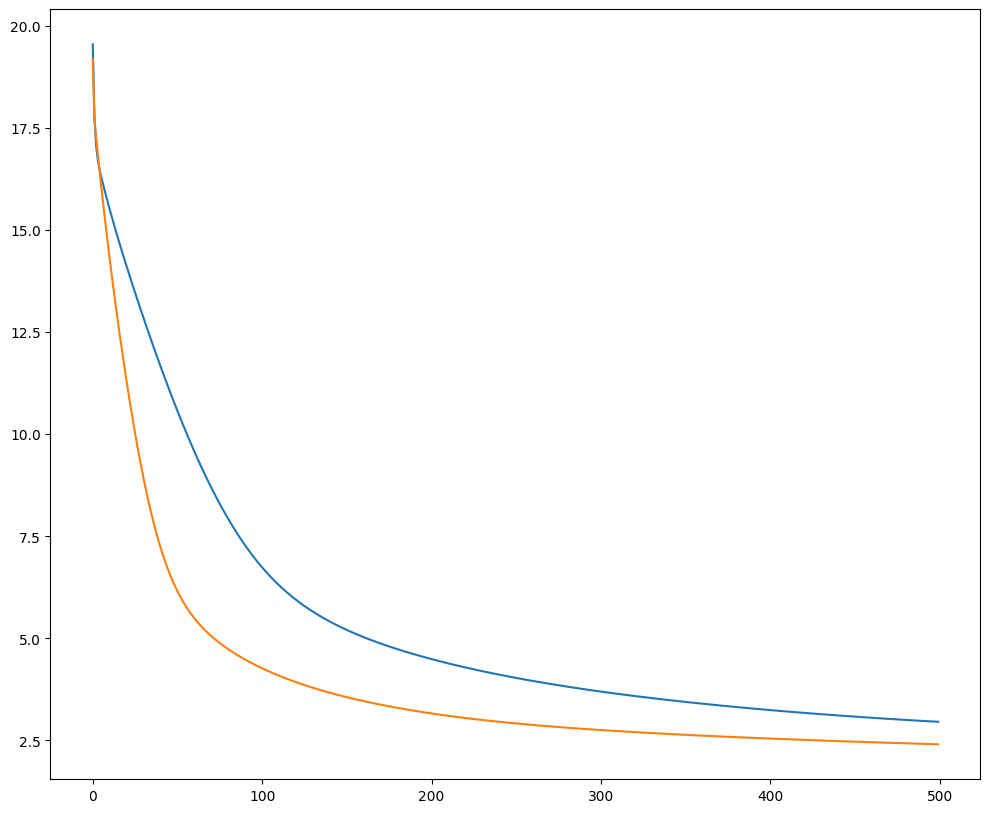

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import DataFrame
import matplotlib.pyplot as plt

import os
print(os.listdir("./data_sets"))

import torch
import torch.nn as nn

raw_data = pd.read_csv('./data_sets/kaggle_house_train.csv')

raw_data.describe()
raw_data.head(10)

numeric_colmuns = []
numeric_colmuns.extend(list(raw_data.dtypes[raw_data.dtypes == np.int64].index))
numeric_colmuns.extend(list(raw_data.dtypes[raw_data.dtypes == np.float64].index))
print(numeric_colmuns)
numeric_colmuns.remove('SalePrice')
numeric_colmuns.append('SalePrice')
numeric_colmuns.remove('Id')

numeric_data = DataFrame(raw_data, columns=numeric_colmuns)
numeric_data.describe()
numeric_data.head(10)

nan_columns = np.any(pd.isna(numeric_data), axis = 0)
nan_columns = list(nan_columns[nan_columns == True].index)
print(nan_columns)

numeric_data['LotFrontage'] = numeric_data['LotFrontage'].fillna(0)
numeric_data['MasVnrArea'] = numeric_data['MasVnrArea'].fillna(0)
numeric_data['GarageYrBlt'] = numeric_data['GarageYrBlt'].fillna(0)

nan_columns = np.any(pd.isna(numeric_data), axis = 0)
nan_columns = list(nan_columns[nan_columns == True].index)
print(nan_columns)

numeric_x_columns = list(numeric_data.columns)
numeric_x_columns.remove('SalePrice')
numeric_y_columns = ['SalePrice']
print(numeric_x_columns)

numeric_x_df = DataFrame(numeric_data, columns=numeric_x_columns)
numeric_y_df = DataFrame(numeric_data, columns=numeric_y_columns)
numeric_x = torch.tensor(numeric_x_df.values, dtype=torch.float)
numeric_y = torch.tensor(numeric_y_df.values, dtype=torch.float)
print(numeric_x.shape)
print(numeric_y.shape)

class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
        
    def forward(self, x):
        y_pred = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(y_pred).clamp(min=0)
        y_pred = self.linear3(y_pred).clamp(min=0)
        y_pred = self.linear4(y_pred)
        return y_pred

H1, H2, H3 = 500, 1000, 200
D_in, D_out = numeric_x.shape[1], numeric_y.shape[1]

model1 = Net(D_in, H1, H2, H3, D_out)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model1.parameters(), lr=1e-4)

losses1 = []

for t in range(500):
    y_pred = model1(numeric_x)
    
    loss = criterion(y_pred, numeric_y)
    print(t, loss.item())
    losses1.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

means, maxs, mins = dict(), dict(), dict()
for col in numeric_data:
    means[col] = numeric_data[col].mean()
    maxs[col] = numeric_data[col].max()
    mins[col] = numeric_data[col].min()

numeric_data = (numeric_data - numeric_data.mean()) / (numeric_data.max() - numeric_data.min())
numeric_x_df = DataFrame(numeric_data, columns=numeric_x_columns)
numeric_y_df = DataFrame(numeric_data, columns=numeric_y_columns)
numeric_x = torch.tensor(numeric_x_df.values, dtype=torch.float)
numeric_y = torch.tensor(numeric_y_df.values, dtype=torch.float)

model2 = Net(D_in, H1, H2, H3, D_out)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-4)

losses2 = []

for t in range(500):
    y_pred = model2(numeric_x)
    
    loss = criterion(y_pred, numeric_y)
    # print(t, loss.item())
    losses2.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# plt.figure(figsize=(12, 10))
# plt.plot(range(len(losses2)), losses2)
# plt.show()

model3 = Net(D_in, H1, H2, H3, D_out)
optimizer = torch.optim.SGD(model3.parameters(), lr=1e-4 * 2)
losses3 = []

for t in range(500):
    y_pred = model3(numeric_x)
    
    loss = criterion(y_pred, numeric_y)
    # print(t, loss.item())
    losses3.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# plt.figure(figsize=(12, 10))
# plt.plot(range(len(losses2)), losses2)
# plt.plot(range(len(losses3)), losses3)
# plt.show()

model4 = Net(D_in, H1, H2, H3, D_out)
optimizer = torch.optim.Adam(model4.parameters(), lr=1e-4 * 2)
losses4 = []

for t in range(500):
    y_pred = model4(numeric_x)
    
    loss = criterion(y_pred, numeric_y)
    # print(t, loss.item())
    losses4.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.figure(figsize=(12, 10))
plt.plot(range(len(losses2)), losses2, label='SGD, 1e-4')
plt.plot(range(len(losses3)), losses3, label='SGD, 2*1e-4')
plt.plot(range(len(losses4)), losses4, label = 'Adam, 2*1e-4')

plt.legend(loc='upper right')
plt.show()

non_numeric_columns = [col for col in list(raw_data.columns) if col not in numeric_colmuns]
non_numeric_columns.remove('Id')
print(non_numeric_columns)

non_numeric_data = DataFrame(raw_data, columns=non_numeric_columns)
non_numeric_data.describe()
non_numeric_data.head(10)
nan_columns = np.any(pd.isna(non_numeric_data), axis=0)
nan_columns = list(nan_columns[nan_columns == True].index)\
print(nan_columns)

for col in nan_columns:
    non_numeric_data[col] = non_numeric_data[col].fillna('N/A')

nan_columns = np.any(pd.isna(non_numeric_data), axis = 0)
nan_columns = list(nan_columns[nan_columns == True].index)
print(nan_columns)

mapping_table = dict()

for col in non_numeric_columns:
    curr_mapping_table = dict()
    
    unique_values = pd.unique(non_numeric_data[col])
    for inx, v in enumerate(unique_values):
        curr_mapping_table[v] = inx + 1
        non_numeric_data[col] = non_numeric_data[col].replace(v, inx + 1)
    
    mapping_table[col] = curr_mapping_table

non_numeric_data.head()

for col in non_numeric_data:
    means[col] = non_numeric_data[col].mean()
    maxs[col] = non_numeric_data[col].max()
    mins[col] = non_numeric_data[col].min()

non_numeric_data = (non_numeric_data - non_numeric_data.mean()) / (non_numeric_data.max() - non_numeric_data.min())

non_numeric_x_df = DataFrame(non_numeric_data, columns=non_numeric_columns)
non_numeric_y_df = DataFrame(numeric_y_df)
non_numeric_x = torch.tensor(non_numeric_x_df.values, dtype=torch.float)
non_numeric_y = torch.tensor(non_numeric_y_df.values, dtype=torch.float)

D_in, D_out = non_numeric_x.shape[1], non_numeric_y.shape[1]
model5 = Net(D_in, H1, H2, H3, D_out)
optimizer = torch.optim.Adam(model5.parameters(), lr=1e-4 * 2)

losses5 = []

for t in range(500):
    y_pred = model5(non_numeric_x)
    
    loss = criterion(y_pred, non_numeric_y)
    print(t, loss.item())
    losses5.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.figure(figsize=(12, 10))
plt.plot(range(len(losses4)), losses4, label = 'Numeric')
plt.plot(range(len(losses5)), losses5, label = 'Non-Numeric')

plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(12, 10))
plt.plot(range(len(losses4[-50:])), losses4[-50:], label = 'Numeric')
plt.plot(range(len(losses5[-50:])), losses5[-50:], label = 'Non-Numeric')

plt.legend(loc='upper right')
plt.show()

x_df = DataFrame(numeric_x_df, columns=numeric_x_columns)
y_df = DataFrame(numeric_y_df)

for col in non_numeric_columns:
    x_df[col] = non_numeric_x_df[col]

x_df.head()

x = torch.tensor(x_df.values, dtype=torch.float)
y = torch.tensor(y_df.values, dtype=torch.float)

D_in, D_out = x.shape[1], y.shape[1]
model6 = Net(D_in, H1, H2, H3, D_out)
optimizer = torch.optim.Adam(model6.parameters(), lr=1e-4 * 2)

losses6 = []

for t in range(500):
    y_pred = model6(x)
    
    loss = criterion(y_pred, y)
    print(t, loss.item())
    losses6.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
plt.figure(figsize=(12, 10))
plt.plot(range(len(losses4)), losses4, label = 'Numeric Only')
plt.plot(range(len(losses5)), losses5, label = 'Non-Numeric Only')
plt.plot(range(len(losses6)), losses6, label = 'Entire Data')

plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(12, 10))
plt.plot(range(len(losses4[-50:])), losses4[-50:], label = 'Numeric Only')
plt.plot(range(len(losses5[-50:])), losses5[-50:], label = 'Non-Numeric Only')
plt.plot(range(len(losses6[-50:])), losses6[-50:], label = 'Entire')

plt.legend(loc='upper right')
plt.show()

# test data
raw_test_data = pd.read_csv('./data_sets/test.csv')
raw_test_data.describe()
raw_test_data.head(10)
test_x = DataFrame(raw_test_data)
test_x = test_x.drop(columns=['Id'])
for col in numeric_x_columns:
    test_x[col].fillna(0)

for col in non_numeric_columns:
    test_x[col] = test_x[col].fillna('N/A')

test_x.head()

for col in mapping_table.keys():
    curr_mapping_table = mapping_table[col]
    for k, v in curr_mapping_table.items():
        test_x[col] = test_x[col].replace(k, v)

test_x.head(10)

unreplaced_columns = []

for col in test_x.columns:
    if 'N/A' in pd.unique(test_x[col]):
        unreplaced_columns.append(col)
        
print(unreplaced_columns)

for col in unreplaced_columns:
    test_x[col] = test_x[col].replace('N/A', 0)

for col in test_x.columns:
    test_x[col] = (test_x[col] - means[col]) / (maxs[col] - mins[col])

test_y = model6(torch.tensor(test_x.values, dtype=torch.float))
result = DataFrame(test_y.data.numpy(), columns=['SalePrice'])
result['SalePrice'] = result['SalePrice'].fillna(0)
result['SalePrice'] = result['SalePrice'] * (maxs['SalePrice'] - mins['SalePrice']) + means['SalePrice']
result['Id'] = np.array(result.index)
result['Id'] = result['Id'] + 1461
result = DataFrame(result, columns=['Id', 'SalePrice'])

print(result)

